In [1]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import time
import sys 
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, confusion_matrix
from tensorflow.keras.layers import AveragePooling2D
import cv2
import re
import pandas as pd
from utils import *

sys.path.append("./models/GPA")
from gpa import GPA
from useful_functions import *

In [2]:
dataset_name = "pedestrians"
result_path = f"./dataset/results/{dataset_name}"
img_path = f"./dataset/baseline/{dataset_name}/"
print(result_path, img_path)

./dataset/results/pedestrians ./dataset/baseline/pedestrians/


In [3]:
# Ground Truth Files
gt_files = glob.glob(img_path + "groundtruth/*png")
gt_files.sort()

# Raw Image Failes
raw_files = glob.glob(img_path + "input/*jpg")
raw_files.sort()

print(len(gt_files), len(raw_files))

1099 1099


In [4]:
# Example Ground Truth
i = 950
gt_img = Image.open(gt_files[i])
gt_img = np.array(gt_img).astype(np.int32) / 255.0
gt_img = (gt_img > 0.5) * 1.0
gt_img.shape

(240, 360)

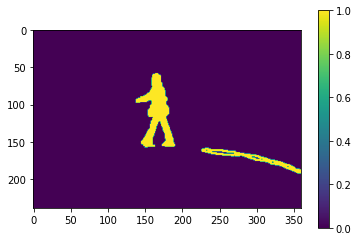

In [5]:
plt.imshow(gt_img)
plt.colorbar()

In [6]:
# Example Raw Image
raw_img = Image.open(raw_files[i])
raw_img = np.array(raw_img).astype(np.int32) / 255.0

In [7]:
p, q = raw_img.shape[0:2]

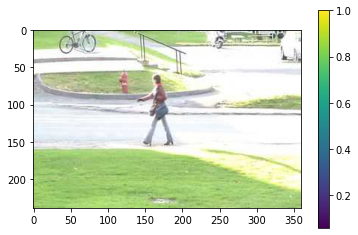

In [8]:
plt.imshow(raw_img)
plt.colorbar()

# GPA

In [9]:
class GPA:
    def __init__(self, G, p, q, train_list, second_smooth=True):
        # basic parameters
        self.G = G
        self.p = p
        self.q = q
        self.train_list = train_list
        self.N0 = len(train_list)
        
        # compute optimal bandwidth
        self.alpha = np.log(p * q) / np.log(self.N0)
        self.bandwidth, self.bandwidth_star = compute_optimal_bandwidths(self.N0, self.alpha)
        
        # generate grid points {x_g^*}
        rng = np.random.default_rng(seed=0)
        tick_list = rng.random(size=G)  # tick list
        self.tick_tensor = tf.concat([tf.ones([1, p, q]) * tick for tick in tick_list], axis=0)
        
        # compute GPA matrix
        self.gpa_matrix, self.train_time = self.compute_GPA_matrix(second_smooth=second_smooth)
        
    def compute_GPA_matrix(self, second_smooth=True):
        gpa_matrix = tf.zeros([self.G, self.p, self.q])
        t1 = time.time()
        for i in range(self.N0):
            test_img = load_and_preprocess_image(self.train_list[i], (self.p, self.q))
            tmp_tensor = (1 / (self.N0 * self.bandwidth)) * (1 / tf.sqrt(2*np.pi)) * tf.exp(-(test_img - self.tick_tensor)**2 / (2 * self.bandwidth**2))
            gpa_matrix += tmp_tensor
        t2 = time.time()
        
        if second_smooth:  # second layer smoothing
            filter_size = 3
            location_filter = get_location_filter(self.p, self.q, self.bandwidth, filter_size)
            gpa_matrix2 = tf.reshape(gpa_matrix, gpa_matrix.shape + (1,))
            gpa_matrix2 = tf.nn.depthwise_conv2d(gpa_matrix2, location_filter, strides=[1, 1, 1, 1], padding='SAME')
            gpa_matrix2 = tf.squeeze(gpa_matrix2)
            t2 = time.time()
            train_time = t2 - t1
#             print(f"--Compute second-smoothed GPA matrix time: {train_time:.4f} seconds.")
            return gpa_matrix2, train_time
        
        train_time = t2 - t1
#         print(f"--Compute GPA matrix time: {train_time:.4f} seconds.")
        return gpa_matrix, train_time
    
    def compute_density(self, raw_img):
        Omega2_star = K_tf(self.tick_tensor - raw_img, self.bandwidth_star)
        Omega1_star = Omega2_star * self.gpa_matrix
        Omega1_star = tf.reduce_sum(Omega1_star, axis=0)
        Omega2_star = tf.reduce_sum(Omega2_star, axis=0)
        GPA_density = Omega1_star / Omega2_star  
        #     plt.imshow(GPA_density)
        #     plt.show()
        return GPA_density
    
    def obtain_mask(self, raw_img, blur_len=4, thres=0.15):
        # GPA density estimator
        t1 = time.time()
        GPA_density = self.compute_density(raw_img)

        # obtain mask
        avg_blur_2d = AveragePooling2D(pool_size=(blur_len, blur_len), strides=1, padding='same')
        GPA_density2 = tf.reshape(GPA_density, GPA_density.shape + (1, 1,))
        GPA_density2 = avg_blur_2d(GPA_density2)
        GPA_density2 = tf.squeeze(GPA_density2)
        mask = (GPA_density2.numpy() < thres) * 1.0
    #     plt.imshow(mask)
    #     plt.show()

        # adjust mask
        mask_uint8 = mask.astype(np.uint8)
        _, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8)
        # stats = np.insert(stats, 5, stats[:, 2] * stats[:, 3], axis=1)
        stats = stats[np.argsort(-stats[:, 4])] # 按照area排序
        stats = stats[1:, ]                     # 去掉背景
    #     print(stats)
        for k in range(stats.shape[0]):
            area = stats[k, 4]
            if area < 150:
    #             print(f"delete the {k}th area")
                x1 = stats[k, 0]
                y1 = stats[k, 1]
                x2 = x1 + stats[k, 2]
                y2 = y1 + stats[k, 3]
                mask[y1:y2, x1:x2] = 0
    #     plt.imshow(mask)
    #     plt.show()
        t2 = time.time()
        gpa_time = t2 - t1
        return mask, gpa_time

In [10]:
gpa_model = GPA(G=500, p=p, q=q, train_list=raw_files)

Optimal bandwidth from Rule of Thumb: 0.01679044266040761
Optimal bandwidth* from GPA estimation: 0.001409594823662179


2024-05-02 14:02:56.451434: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 14:02:57.263718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:b3:00.0, compute capability: 6.0
2024-05-02 14:03:06.746103: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


In [11]:
# Example Raw Image
raw_img = Image.open(raw_files[i])
raw_img = np.array(raw_img).astype(np.int32) / 255.0
test_img = raw_img.mean(axis=2)

In [12]:
gpa_mask, gpa_time = gpa_model.obtain_mask(test_img)

In [13]:
results_list = []

for i in range(len(raw_files)):
    # ground truth and raw image
    gt_img = Image.open(gt_files[i])
    gt_img = np.array(gt_img)  # with shape (p, q)
    gt_img *= (gt_img == 255)  # reserve the Moving class with value 255
    gt_img = gt_img.astype(np.float64) / 255.0
    y_true = gt_img.ravel()
    raw_img = load_and_preprocess_image(raw_files[i], (p, q))
    
    # obtain mask
    gpa_mask, gpa_time = gpa_model.obtain_mask(raw_img, blur_len=4, thres=0.15)
    
    # compute metrics
    y_predict = gpa_mask.ravel()
    conf_mat = confusion_matrix(y_true, y_predict).ravel()  # confusion matrix
    if len(conf_mat) == 1:
        tn, fp, fn, tp = conf_mat[0], 0, 0, 0
    else:
        tn, fp, fn, tp = conf_mat
    
    # record the results
    results_list.append([dataset_name, i, gpa_time, tn, fp, fn, tp])

In [14]:
results_df = pd.DataFrame(results_list, columns=["dataset", "index", "gpa_time", "tn", "fp", "fn", "tp"])
results_df.head()

,dataset,index,gpa_time,tn,fp,fn,tp
0,pedestrians,0,0.007810,86400,0,0,0
1,pedestrians,1,0.007531,86400,0,0,0
2,pedestrians,2,0.007593,86400,0,0,0
3,pedestrians,3,0.007513,86400,0,0,0
4,pedestrians,4,0.007513,86400,0,0,0


In [15]:
total_time = results_df.gpa_time.sum()
avg_time = total_time / results_df.shape[0]
avg_time

0.0077527343847189735

In [16]:
total_fp = results_df.fp.sum()
total_fn = results_df.fn.sum()
total_tp = results_df.tp.sum()

In [17]:
Precision = total_tp / (total_tp + total_fp)
Recall = total_tp / (total_tp + total_fn)
f1 = 2 * Precision * Recall / (Precision + Recall)

In [18]:
f1, Recall, Precision  #     gpa_mask, gpa_time = gpa_model.obtain_mask(raw_img, blur_len=4, thres=0.15)

(0.7354647512369088, 0.7420721400228363, 0.7289739880160957)

In [ ]:
# metrics
y_predict = mask.ravel()
conf_mat = confusion_matrix(y_true, y_predict).ravel()  # confusion matrix
if len(conf_mat) == 1:
    tn, fp, fn, tp = conf_mat[0], 0, 0, 0
else:
    tn, fp, fn, tp = conf_mat

In [9]:
G = 500               # number of grid points
p = raw_img.shape[0]  # figure height
q = raw_img.shape[1]  # figure width
N0 = len(raw_files)   # number of images to compute the GPA matrix

alpha = np.log(p * q) / np.log(N0)
bandwidth, bandwidth_star = compute_optimal_bandwidths(N0, alpha)

Optimal bandwidth from Rule of Thumb: 0.01679044266040761
Optimal bandwidth* from GPA estimation: 0.001409594823662179


In [10]:
rng = np.random.default_rng(seed=0)

# tick list
tick_list = rng.random(size=G)
tick_tensor = tf.concat([tf.ones([1, p, q]) * tick for tick in tick_list], axis=0)

# GPA matrix
j = 0
GPA_matrix = tf.zeros([G, p, q])

# 【尝试】使用全部的数据
n = len(raw_files)
t1 = time.time()
for i in range(n):
#     print(f"--Load the {j}th image to compute GPA matrix with [index={i}]--")
    test_img = load_and_preprocess_image(raw_files[i], (p, q))
    tmp_tensor = (1 / (n * bandwidth)) * (1 / tf.sqrt(2*np.pi)) * tf.exp(-(test_img - tick_tensor)**2 / (2 * bandwidth**2))
    GPA_matrix += tmp_tensor
    j += 1
t2 = time.time()

2024-04-13 13:00:52.076212: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 13:00:52.607024: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:9c:00.0, compute capability: 8.0


In [11]:
gpa_mat_time = t2 - t1

In [12]:
filter_size = 3
location_filter = get_location_filter(p, q, bandwidth, filter_size)

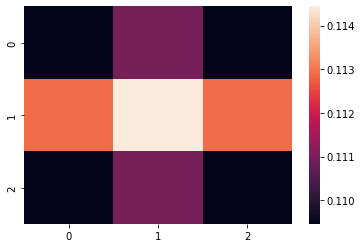

In [13]:
# show the location filter in heatmap
sns.heatmap(location_filter[:, :, 0, 0])
plt.show()

In [14]:
GPA_matrix2 = tf.reshape(GPA_matrix, GPA_matrix.shape + (1,))
# second layer smoothing
GPA_matrix2 = tf.nn.depthwise_conv2d(GPA_matrix2, location_filter, strides=[1, 1, 1, 1], padding='SAME')
GPA_matrix2 = tf.squeeze(GPA_matrix2)

2024-04-13 13:00:59.182044: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


In [15]:
# plt.imshow(GPA_matrix[2, :, :])
# plt.title(f"First Layer Smoothing")
# plt.colorbar()
# plt.show()
# plt.imshow(GPA_matrix2[2, :, :])
# plt.title(f"Second Layer Smoothing")
# plt.colorbar()
# plt.show()

## GPA 图片密度估计

In [16]:
# Example Ground Truth
i = 0
# ground truth and raw image
gt_img = np.array(Image.open(gt_files[i])).astype(np.int32) / 255.0
gt_img = (gt_img > 0.5) * 1.0

# Example Raw Image
raw_img = Image.open(raw_files[i])
raw_img = np.array(raw_img).astype(np.int32) / 255.0
test_img = raw_img.mean(axis=2)

In [17]:
gt_img.sum()

0.0

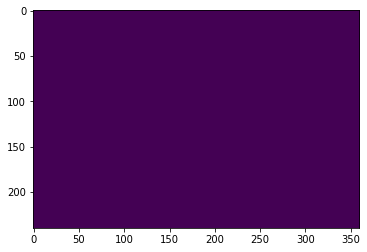

In [18]:
plt.imshow(gt_img)

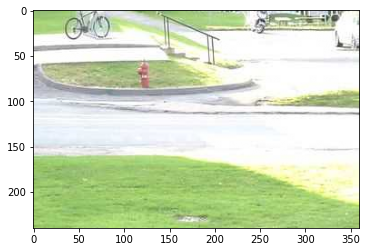

In [19]:
plt.imshow(raw_img)

In [20]:
# GPA 估计
t1 = time.time()
Omega2_star = K_tf(tick_tensor - test_img, bandwidth_star)
print(Omega2_star.shape)
Omega1_star = Omega2_star * GPA_matrix2
Omega1_star = tf.reduce_sum(Omega1_star, axis=0)
Omega2_star = tf.reduce_sum(Omega2_star, axis=0)
GPA_density = Omega1_star / Omega2_star
t2 = time.time()
print(f"Computing GPA Density Time: {t2 - t1}")

(500, 240, 360)
Computing GPA Density Time: 0.006161212921142578


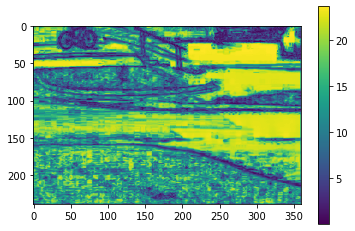

In [21]:
plt.imshow(GPA_density)
plt.colorbar()
plt.show()

In [22]:
blur_len = 5
avg_blur_2d = AveragePooling2D(pool_size=(blur_len, blur_len), strides=1, padding='same')
GPA_density2 = tf.reshape(GPA_density, GPA_density.shape + (1, 1,))
GPA_density2 = avg_blur_2d(GPA_density2)
GPA_density2 = tf.squeeze(GPA_density2)

# GPA_density2 = GPA_density

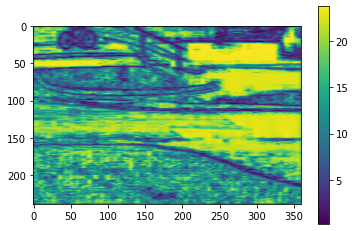

In [23]:
plt.imshow(GPA_density2)
plt.colorbar()
plt.show()

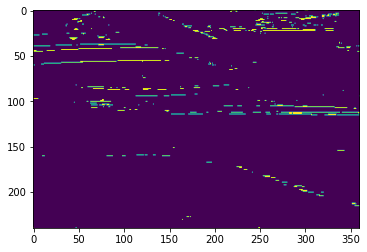

In [24]:
mask = (GPA_density2.numpy() < 2) * 1.0
plt.imshow(mask)

In [25]:
mask_uint8 = mask.astype(np.uint8)
_, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8)
# stats = np.insert(stats, 5, stats[:, 2] * stats[:, 3], axis=1)
stats = stats[np.argsort(-stats[:, 4])] # 按照area排序
stats = stats[1:, ]                     # 去掉背景
stats[:5, ]

array([[271, 112,  67,   4, 121],
       [  9,  56,  83,   4,  86],
       [253,  21,  58,   2,  72],
       [ 52,  37,  61,   2,  67],
       [288, 105,  58,   3,  63]], dtype=int32)

In [26]:
for k in range(stats.shape[0]):
    area = stats[k, 4]
    if area < 220:
        print(f"delete the {k}th area")
        x1 = stats[k, 0]
        y1 = stats[k, 1]
        x2 = x1 + stats[k, 2]
        y2 = y1 + stats[k, 3]
        mask[y1:y2, x1:x2] = 0

delete the 0th area
delete the 1th area
delete the 2th area
delete the 3th area
delete the 4th area
delete the 5th area
delete the 6th area
delete the 7th area
delete the 8th area
delete the 9th area
delete the 10th area
delete the 11th area
delete the 12th area
delete the 13th area
delete the 14th area
delete the 15th area
delete the 16th area
delete the 17th area
delete the 18th area
delete the 19th area
delete the 20th area
delete the 21th area
delete the 22th area
delete the 23th area
delete the 24th area
delete the 25th area
delete the 26th area
delete the 27th area
delete the 28th area
delete the 29th area
delete the 30th area
delete the 31th area
delete the 32th area
delete the 33th area
delete the 34th area
delete the 35th area
delete the 36th area
delete the 37th area
delete the 38th area
delete the 39th area
delete the 40th area
delete the 41th area
delete the 42th area
delete the 43th area
delete the 44th area
delete the 45th area
delete the 46th area
delete the 47th area
de

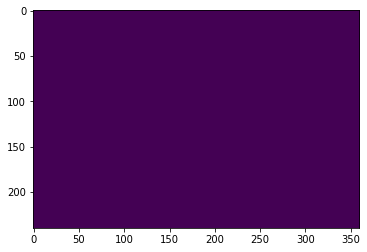

In [27]:
plt.imshow(mask)

In [28]:
y_predict = mask.ravel()
y_true = gt_img.ravel()
f1 = f1_score(y_true, y_predict)     # F1-score
recall = recall_score(y_true, y_predict) #recall
print(f1, recall)

0.0 0.0


/root/miniconda3/envs/myconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/root/miniconda3/envs/myconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# mean performance

In [111]:
results_list = []
debug = 0

In [112]:
for i in range(len(raw_files)):
    # ground truth and raw image
    gt_img = Image.open(gt_files[i])
    gt_img = np.array(gt_img)  # with shape (p, q)
    gt_img *= (gt_img == 255)  # reserve the Moving class with value 255
    gt_img = gt_img.astype(np.float64) / 255.0
    y_true = gt_img.ravel()
    raw_img = load_and_preprocess_image(raw_files[i], (p, q))
    
    # GPA density estimator
    t1 = time.time()
    Omega2_star = K_tf(tick_tensor - raw_img, bandwidth_star)
    Omega1_star = Omega2_star * GPA_matrix2
    Omega1_star = tf.reduce_sum(Omega1_star, axis=0)
    Omega2_star = tf.reduce_sum(Omega2_star, axis=0)
    GPA_density = Omega1_star / Omega2_star
#     plt.imshow(GPA_density)
#     plt.show()
    
    # obtain mask
    blur_len = 4
    avg_blur_2d = AveragePooling2D(pool_size=(blur_len, blur_len), strides=1, padding='same')
    GPA_density2 = tf.reshape(GPA_density, GPA_density.shape + (1, 1,))
    GPA_density2 = avg_blur_2d(GPA_density2)
    GPA_density2 = tf.squeeze(GPA_density2)
    mask = (GPA_density2.numpy() < 1.5) * 1.0
#     plt.imshow(mask)
#     plt.show()
#     mask = (GPA_density.numpy() < 3) * 1.0

    # adjust mask
    mask_uint8 = mask.astype(np.uint8)
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8)
    # stats = np.insert(stats, 5, stats[:, 2] * stats[:, 3], axis=1)
    stats = stats[np.argsort(-stats[:, 4])] # 按照area排序
    stats = stats[1:, ]                     # 去掉背景
#     print(stats)
    for k in range(stats.shape[0]):
        area = stats[k, 4]
        if area < 150:
#             print(f"delete the {k}th area")
            x1 = stats[k, 0]
            y1 = stats[k, 1]
            x2 = x1 + stats[k, 2]
            y2 = y1 + stats[k, 3]
            mask[y1:y2, x1:x2] = 0
#     plt.imshow(mask)
#     plt.show()
    t2 = time.time()
    gpa_time = t2 - t1
    
    # metrics
    y_predict = mask.ravel()
    conf_mat = confusion_matrix(y_true, y_predict).ravel()  # confusion matrix
    if len(conf_mat) == 1:
        tn, fp, fn, tp = conf_mat[0], 0, 0, 0
    else:
        tn, fp, fn, tp = conf_mat
    
    # record the results
    results_list.append([dataset_name, i, gpa_time, tn, fp, fn, tp])
#     results_df = pd.DataFrame(results_list, columns=["dataset", "index", "gpa_time", "tn", "fp", "fn", "tp"])
#     results_df.to_csv(f"./gpa-{dataset_name}.csv")

In [113]:
results_df = pd.DataFrame(results_list, columns=["dataset", "index", "gpa_time", "tn", "fp", "fn", "tp"])
results_df.head()

,dataset,index,gpa_time,tn,fp,fn,tp
0,pedestrians,0,0.006884,86400,0,0,0
1,pedestrians,1,0.006617,86400,0,0,0
2,pedestrians,2,0.006418,86400,0,0,0
3,pedestrians,3,0.006467,86400,0,0,0
4,pedestrians,4,0.006443,86400,0,0,0


In [114]:
total_time = results_df.gpa_time.sum()
avg_time = total_time / results_df.shape[0]
avg_time

0.0058438914596654805

In [115]:
avg_time = (total_time + gpa_mat_time) / results_df.shape[0]
avg_time

0.010552590928151457

In [116]:
total_fp = results_df.fp.sum()
total_fn = results_df.fn.sum()
total_tp = results_df.tp.sum()

In [117]:
Precision = total_tp / (total_tp + total_fp)
Recall = total_tp / (total_tp + total_fn)
f1 = 2 * Precision * Recall / (Precision + Recall)

In [118]:
f1, Recall, Precision

(0.7052976960145084, 0.8614439333275696, 0.5970718261155256)

In [94]:
f1, Recall, Precision

(0.7103095635412856, 0.8305523341611241, 0.620479915188554)